In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import argparse
import sys
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import influence
from mnist_convnet import deepnn
from utils import corrupt_mnist
import copy

np.random.seed(1)

FLAGS = None

# Import data
mnist = corrupt_mnist(input_data.read_data_sets("mnist_data", one_hot=True), 0.03)

# Create the model
with tf.name_scope("net"):
    input_ph = tf.placeholder(tf.float32, [None, 784])
    y, weights = deepnn(input_ph)

# Define loss and optimizer
with tf.name_scope("loss"):
    y_ = tf.placeholder(tf.float32, [None, 10], name="y_target")
    batch_loss = tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y)
    regularization = tf.reduce_sum( [tf.nn.l2_loss(w) for w in weights])
    cross_entropy = tf.reduce_sum(batch_loss) + regularization * 0.001

lr = tf.Variable(0.1)
opt = tf.train.AdamOptimizer(lr)
grads_and_vars = opt.compute_gradients(cross_entropy)
train_step = opt.apply_gradients(grads_and_vars)

# Test trained model
with tf.name_scope("accuracy"):
    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

saver = tf.train.Saver()
sess = tf.InteractiveSession()

tf.global_variables_initializer().run()

gs = [g for g,v in grads_and_vars if g is not None]

Extracting mnist_data/train-images-idx3-ubyte.gz
Extracting mnist_data/train-labels-idx1-ubyte.gz
Extracting mnist_data/t10k-images-idx3-ubyte.gz
Extracting mnist_data/t10k-labels-idx1-ubyte.gz


In [2]:
#saver.restore(sess, "/home/cgel/deep_quad/mnist_convnet_corrupted.ckpt")

summary_writter = tf.summary.FileWriter("./Hvp_summaries", sess.graph)

In [3]:
test_feed_dic = {input_ph: mnist.test.images, y_: mnist.test.labels}

batch_xs, batch_ys = mnist.train.next_batch(mnist.test.images.shape[0])
train_feed_dic = {input_ph:batch_xs, y_:batch_ys}

testset = (mnist.test.images, mnist.test.labels)
trainset = (mnist.train.images, mnist.train.labels)
#trainset = (mnist.train.images[0:10000], mnist.train.labels[0:10000])

In [20]:
scale = float(len(trainset[0]))
inf = influence.Influence(cross_entropy/scale, input_ph, y_, testset, trainset, cg_iters = 30, dampening=0.001, vervose=3)

error: 0.11355
- iter: 0
Error: 0.162412480722
dad: 0.000178858786579
alpha: 72.0938086232
beta: 2.04564644968
Ad scaling: 0.0242070441411
- iter: 1
Error: 0.112668858627
dad: 0.000848822907774
alpha: 31.0757582494
beta: 0.481247986026
Ad scaling: 0.0224415272928
- iter: 2
Error: 0.0951080621811
dad: 0.000281123951726
alpha: 45.1554216454
beta: 0.712569245963
Ad scaling: 0.0184562325042
- iter: 3
Error: 0.0672559756662
dad: 0.000220587374809
alpha: 41.0066388405
beta: 0.500065257628
Ad scaling: 0.0179880184422
- iter: 4
Error: 0.0599372183621
dad: 0.000113202056796
alpha: 39.9583172315
beta: 0.794203332819
Ad scaling: 0.0217350714731
- iter: 5
Error: 0.0395181733315
dad: 0.000155126896407
alpha: 23.1582698209
beta: 0.434711025004
Ad scaling: 0.0304292269451
- iter: 6
Error: 0.0301927786964
dad: 4.48930097367e-05
alpha: 34.7868532922
beta: 0.583730404486
Ad scaling: 0.0240857999965
- iter: 7
Error: 0.017551961602
dad: 2.88606135299e-05
alpha: 31.5864358464
beta: 0.337944331296
Ad scalin

In [6]:
#inf.recompute_s(cg_iters = 20, dampening=4e-2, vervose=1)

In [46]:
trainset_inf = []
for i in range(len(mnist.train.labels)):
    z_inf = z = (mnist.train.images[i:i+1], mnist.train.labels[i:i+1])
    influ, z_grad = inf.of_and_g(z)
    trainset_inf.append( (influ, i))
    if i % 1000==0:
        print(i)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000
26500
27000
27500
28000
28500
29000
29500
30000
30500
31000
31500
32000
32500
33000
33500
34000
34500
35000
35500
36000
36500
37000
37500
38000
38500
39000
39500
40000
40500
41000
41500
42000
42500
43000
43500
44000
44500
45000
45500
46000
46500
47000
47500
48000
48500
49000
49500
50000
50500
51000
51500
52000
52500
53000
53500
54000
54500


In [57]:
influences = [0]*len(mnist.train.labels)
for i in range(len(mnist.train.labels)):
    j = trainset_inf[i][1]
    influences[j] = trainset_inf[i][0]

In [49]:
trainset_inf.sort()

In [54]:
rank = np.abs(trainset_inf)

In [59]:
rank.sort()

In [53]:
trainset_inf[0:10]

[(-5.7187035693573307e-05, 5632),
 (-5.7176692605409585e-05, 4071),
 (-5.5964669225971875e-05, 47266),
 (-5.3027766401925192e-05, 11256),
 (-4.8352770130932754e-05, 16297),
 (-4.7952599242506722e-05, 5952),
 (-4.7247628367053096e-05, 34272),
 (-4.5420109124449937e-05, 15786),
 (-4.5190334896361151e-05, 16175),
 (-4.4237209845476855e-05, 8692)]

In [52]:
trainset_inf[-10:-1]

[(5.1811764020470719e-05, 12254),
 (5.5368290608592829e-05, 17454),
 (5.7482173112077817e-05, 51698),
 (5.8116521792328513e-05, 9700),
 (5.859773315108896e-05, 54783),
 (6.0696809478955061e-05, 31141),
 (6.3410568113653198e-05, 37399),
 (6.384117171931436e-05, 10744),
 (6.7289159892069961e-05, 15775)]

In [ ]:
influences_corrupted = []
influences_non_corrupted = []
grads_corrupted = []
grads_non_corrupted = []
#size = len(mnist.train.labels)
size = 1000
for i in range(size):
    z = (mnist.train.images[i:i+1], mnist.train.labels[i:i+1])
    influ, z_grad = inf.of_and_g(z)
    if mnist.train.corrupted_mask[i]:
        influences_corrupted.append(influ)
        grads_corrupted.append(z_grad)
    else:
        influences_non_corrupted.append(influ)
        grads_non_corrupted.append(z_grad)
all_influences = influences_corrupted + influences_non_corrupted
all_grads = grads_corrupted + grads_non_corrupted

In [83]:
print("non corrupted")
print("mean",np.mean( influences_non_corrupted))
print("std",np.std( influences_non_corrupted))

non corrupted
mean -6.47728385977e-08
std 1.21111189844e-05


In [84]:
print("corrupted")
print("mean",np.mean( influences_corrupted))
print("std",np.std( influences_corrupted))

corrupted
mean -1.88751401152e-06
std 5.31467498935e-06


In [16]:
inf.s = influence.lset(inf.s, 1.)

In [21]:
#def train(n, mnist=mnist, learning_rate=0.1e-4):
#    sess.run(tf.assign(lr, learning_rate))
#    for _ in range(n):
#        batch_xs, batch_ys = mnist.train.next_batch(64)
#        sess.run(train_step, feed_dict={input_ph: batch_xs, y_: batch_ys})
        
def test():
    test_acc, test_loss = sess.run([accuracy, cross_entropy], feed_dict={input_ph: mnist.test.images,
                                  y_: mnist.test.labels})
    train_acc, train_loss = sess.run([accuracy, cross_entropy], feed_dict=train_feed_dic)
    print("test acc", test_acc)
    print("test loss", test_loss)
    print("train acc", train_acc)
    print("train loss", train_loss) 
    print("---")
    
def testset_loss():
    return sess.run(cross_entropy, feed_dict={input_ph: mnist.test.images, y_: mnist.test.labels})

def train(n, trainset, learning_rate=0.1e-4):
    sess.run(tf.assign(lr, learning_rate))
    for _ in range(n):
        batch_xs, batch_ys = trainset.next_batch(500)
        sess.run(train_step, feed_dict={input_ph: batch_xs, y_: batch_ys})

In [22]:
# return a new dataset 
def mnist_i(i):
    new_mnist = copy.deepcopy(mnist)
    new_len = new_mnist.train.images.shape[0] -1
    new_images_shape = [new_len] + list(new_mnist.train.images.shape[1:])
    new_labels_shape = [new_len] + list(new_mnist.train.labels.shape[1:])
    new_mnist.train.images.resize(new_images_shape)
    new_mnist.train.labels.resize(new_labels_shape)
    new_mnist.train.images[:] = np.delete(mnist.train.images, i, axis=0)
    new_mnist.train.labels[:] = np.delete(mnist.train.labels, i, axis=0)
    return new_mnist

In [23]:
# return a new dataset 
def mnist_i2(i):
    return (np.delete(mnist.train.images, i, axis=0), np.delete(mnist.train.labels, i, axis=0))

In [ ]:
class Dataset:
    def __init__(self, data):
        self.images = data[0]
        self.labels = data[1]
        self.a = 0 
        self.b = None 
        
    def next_batch(self, batch_size):
        if self.b == None or self.b == len(self.labels):
            self.a = 0
            self.b = batch_size
        else:
            self.a = self.b
            self.b = min(self.a + batch_size, len(self.labels) )
            
        return (self.images[self.a:self.b], self.labels[self.a:self.b])

In [ ]:
# leave one out retraining 
subset = rank[0:5]
influence_acc = []
grads_l = []
saver.restore(sess, "/home/cgel/deep_quad/mnist_convnet_corrupted.ckpt")
base_testset_loss = testset_loss()
for _,i in subset:
    print(i)
    z = (mnist.train.images[i:i+1], mnist.train.labels[i:i+1])
    z_influ, z_grad = inf.of_and_g(z)
    grads_l.append(z_grad*scale)
    new_mnist = Dataset(mnist_i2(i))
    train(15000, new_mnist, learning_rate=1e-7)
    d_loss = base_testset_loss - testset_loss()
    influence_acc.append( (z_influ * scale, d_loss) )
    saver.restore(sess, "/home/cgel/deep_quad/mnist_convnet_corrupted.ckpt")

5632.0


/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


4071.0
47266.0


In [47]:
np.save("influence-d_loss", influence_acc)

In [62]:
infs = []
d_losses = []
print("influence", "d_loss")
for pair in influence_acc:
    infs.append(pair[0])
    d_losses.append(pair[1])
    print(pair[0], pair[1])

influence d_loss
-3.42003487964 -2.51477
-3.42988441918 -2.51343
-3.31553294259 -2.43469
-3.18449001304 -2.54724
-2.89721718932 -2.53955
-2.80471673122 -2.55725
-2.8584670027 -2.57825
-2.72052093322 -2.47253
-2.71432353466 -2.61023
-2.66856245442 -2.5813
-2.60808382287 -2.50586
-2.50794371573 -2.45508
-2.50656829854 -2.54211
-2.39679929708 -2.54114
-2.42648161668 -2.46692
-2.33718128971 -2.50305
-2.22871083264 -2.53137
-2.13204273027 -2.54834
-2.0511296082 -2.61658
-2.08956744985 -2.5564


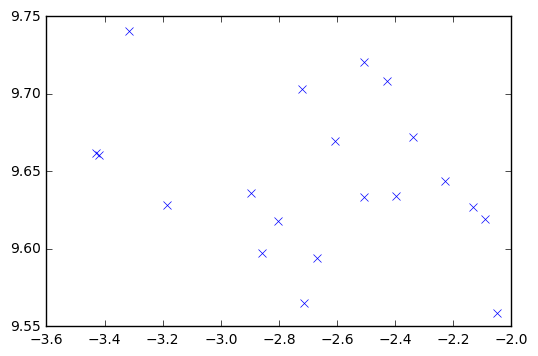

In [63]:
plt.plot(infs, d_losses - avrg, "x")

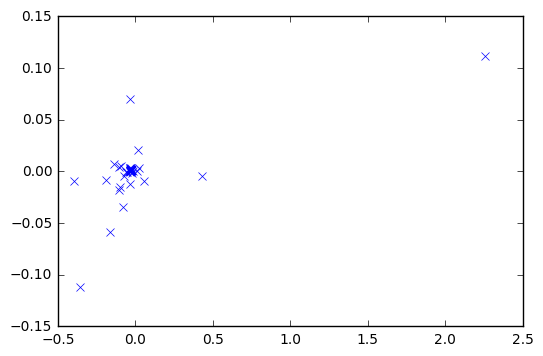

In [43]:
plt.plot(infs, d_losses - avrg, "x")

In [39]:
influence_acc
cu = 0
for i in range(len(influence_acc)):
    print(influence_acc[i], mnist.train.corrupted_mask[i])
    cu += influence_acc[i][1]

(-0.027689653809073733, -12.173828) False
(2.253888293622941, -12.064087) False
(-0.057892054706257245, -12.17627) True
(-0.028630717219882418, -12.174316) False
(-0.015116766469772114, -12.174805) False
(0.017373136347864637, -12.154297) False
(-0.027889592524935058, -12.174683) False
(-0.028365732707147373, -12.173828) False
(-0.028661911857935651, -12.174316) False
(-0.032132640476745244, -12.174683) False
(0.42866204244207395, -12.179932) False
(-0.029064536376452454, -12.174072) False
(-0.16695554828166648, -12.234497) False
(-0.094426384465995383, -12.169678) False
(-0.099014407147698935, -12.190796) True
(0.053566588407716331, -12.184204) False
(-0.053189263293645928, -12.175903) False
(-0.028707009974843212, -12.174072) False
(-0.02871165062694192, -12.174072) False
(-0.029057295559478669, -12.173828) False
(-0.028698393551712664, -12.174194) False
(0.0093212496818373403, -12.175415) False
(-0.031820806585119987, -12.175049) False
(-0.031968775614441003, -12.173096) False
(-0.1

In [42]:
avrg = cu/len(influence_acc)

In [35]:
saver.restore(sess, "/home/cgel/deep_quad/mnist_convnet_corrupted.ckpt")
base_testset_loss = testset_loss()
train(10000, mnist.train, learning_rate=1e-7)
d_loss = base_testset_loss - testset_loss()
print(d_loss)

-4.37305


In [37]:
1

1

In [86]:
saver.restore(sess, "/home/cgel/deep_quad/mnist_convnet_corrupted.ckpt")

In [87]:
sess.run(tf.global_variables_initializer())

In [10]:
test()
for i in range(10):
    train(10000, mnist.train)
    test()
print("XXXX")
for i in range(10):
    train(10000, mnist.train, 1e-5)
    test() 
print("XXXX")
for i in range(10):
    train(10000, mnist.train, 1e-6)
    test()
print("XXXX")
for i in range(10):
    train(10000, mnist.train, 1e-7)
    test()

test acc 0.0846
test loss 30870.3
train acc 0.0891
train loss 31078.4
---
test acc 0.9632
test loss 1621.01
train acc 0.9499
train loss 2671.71
---
test acc 0.9712
test loss 1323.3
train acc 0.9639
train loss 1933.37
---
test acc 0.9732
test loss 1229.11
train acc 0.9698
train loss 1451.83
---
test acc 0.9725
test loss 1166.37
train acc 0.9756
train loss 1049.5
---
test acc 0.9734
test loss 1083.27
train acc 0.9822
train loss 731.857
---
test acc 0.9726
test loss 1060.42
train acc 0.9905
train loss 486.994
---
test acc 0.9716
test loss 1048.83
train acc 0.9961
train loss 306.672
---
test acc 0.9711
test loss 1017.23
train acc 0.9983
train loss 184.784
---
test acc 0.9701
test loss 1028.05
train acc 0.9988
train loss 113.906
---
test acc 0.9704
test loss 1045.9
train acc 0.9994
train loss 69.462
---
XXXX
test acc 0.9698
test loss 1084.29
train acc 0.9999
train loss 42.4314
---
test acc 0.9689
test loss 1126.6
train acc 0.9999
train loss 32.3282
---
test acc 0.9689
test loss 1157.06
trai

In [11]:
gs_np, loss = sess.run([gs, cross_entropy], feed_dict=train_feed_dic)
print("train")
print("grad norm",influence.lnorm(gs_np))
print("loss", loss)

train
grad norm 18.5843177063
loss 5.1857


In [12]:
gs_np, loss = sess.run([gs, cross_entropy], feed_dict=test_feed_dic)
print("test")
print("grad norm",influence.lnorm(gs_np))
print("loss", loss)

test
grad norm 6245.49428715
loss 1277.04


In [18]:
saver.save(sess, "/home/cgel/deep_quad/mnist_convnet_corrupted.ckpt")

'/home/cgel/deep_quad/mnist_convnet_corrupted.ckpt'